# **Desafio 1: Previsão de custos médicos**

Primeiro passo foi importar as bibliotecas para poder fazer as manipulações dos dados e gerar os gráficos. E carregar os dados do dataset Medical Cost Personal Dataset, disponivel no Kaggle.

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"
df = pd.read_csv(url)

print(df.head())
print(df.info())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


Aqui utilizei o ProfileReport para entender melhor os dados.

In [42]:
!pip install -U ydata-profiling

In [43]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="Relatório_Medical", explorative=True)
profile.to_file("Relatório_Medical.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 7/7 [00:00<00:00, 57.74it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Para entender o impacto do tabagismo nos custos, gerei esse gráfico onde mostra a media dos custos entre as fumantes e não fumantes. Aqui já podemos observar que sim, o tabagismo tem uma forte influencia nos custos médicos.

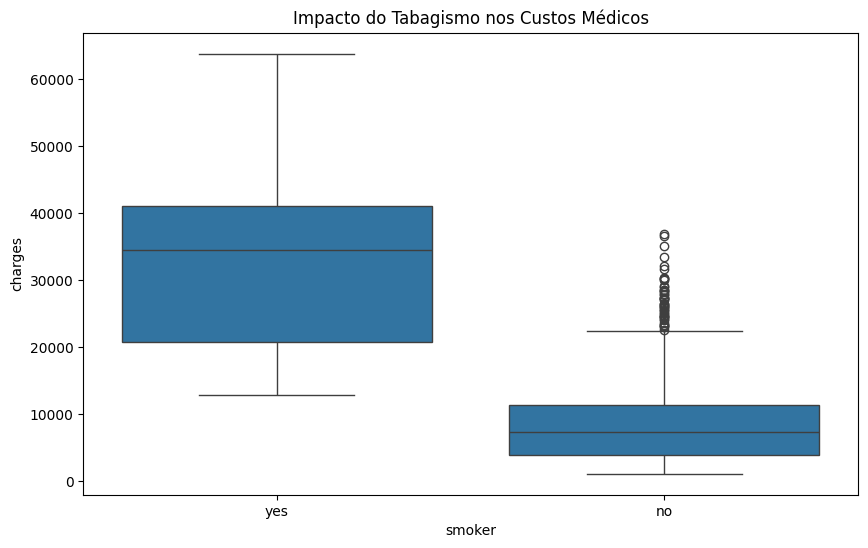

In [44]:
plt.figure(figsize=(10,6))
sns.boxplot(x='smoker', y='charges', data=df)
plt.title('Impacto do Tabagismo nos Custos Médicos')
plt.show()

Nessa etapa, manipulei os dados e separei uma parte deles para treino do modelo e outra para teste.

In [45]:
#Aqui transformei as strings em numeros para que o meu modelo possa entender:
df['smoker'] = df['smoker'].map({'yes': 1, 'no': 0})

df['sex'] = df['sex'].map({'female': 0, 'male': 1})

df['region'] = df['region'].apply({'southwest':1, 'southeast':2, 'northwest':3, 'northeast':4}.get)

#Aqui defini as minhas caracteristicas e minha varialvel alvo:
X = df[['age', 'sex', 'bmi', 'children', 'smoker','region']]
y = df['charges']

#Dividi os dados: uma parte para a IA estudar (Treino) e outra para o teste final (80% treino e 20% teste)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dados prontos!")
print(f"Treinaremos com {len(X_train)} pessoas e testaremos com {len(X_test)} pessoas.")

Dados prontos!
Treinaremos com 1070 pessoas e testaremos com 268 pessoas.


In [46]:
print(df.head())
#visualizando como ficou minha tabela após a transformação das string:

   age  sex     bmi  children  smoker  region      charges
0   19    0  27.900         0       1       1  16884.92400
1   18    1  33.770         1       0       2   1725.55230
2   28    1  33.000         3       0       2   4449.46200
3   33    1  22.705         0       0       3  21984.47061
4   32    1  28.880         0       0       3   3866.85520


In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

#Escolha do modelo:
modelo = LinearRegression()

#A IA vai olhar o X_train e o y_train e tentar descobrir a relação matemática entre eles.
modelo.fit(X_train, y_train)

#Agora pedimos para a IA prever os valores de quem ela nunca viu (X_test)
previsoes = modelo.predict(X_test)

# Aqui vemos através do erro médio e da precisão o quanto ela errou e acertou (uma boa metrica para avaliar esse modelo):
erro_medio = mean_absolute_error(y_test, previsoes)
precisao_r2 = r2_score(y_test, previsoes)

print(f"Erro Médio: R$ {erro_medio:.2f}")
print(f"Precisão (R²): {precisao_r2:.2f}")

Erro Médio: R$ 4186.51
Precisão (R²): 0.78


Podemos observar que o modelo teve uma precisao de 78% e que pode errar R$4186 para mais ou para menos em uma previsão de custo.

Aqui eu fiz o teste com outro modelo (Random Forest) e ele obteve uma precisão melhor de 83% e o erro medio menor de R$2671, ou seja, é um modelo que erra menos na previsão dos custos.

In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

# Definir X e y
X = df.drop("charges", axis=1)
y = df["charges"]

# Configurar K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Modelo Random Forest
rf_model = RandomForestRegressor(
    n_estimators=200,   # número de árvores
    max_depth=None,     # profundidade ilimitada
    random_state=42,
    n_jobs=-1           # usa todos os núcleos disponíveis
)

# Avaliar R²
r2_scores = cross_val_score(rf_model, X, y, cv=kf, scoring="r2")
print("Scores por fold (R²):", r2_scores)
print("Média R²:", np.mean(r2_scores))
print("Desvio padrão R²:", np.std(r2_scores))

# Avaliar MAE
neg_mae_scores = cross_val_score(rf_model, X, y, cv=kf, scoring="neg_mean_absolute_error")
mae_scores = -neg_mae_scores
print("MAE por fold:", mae_scores)
print("Média MAE:", np.mean(mae_scores))
print("Desvio padrão MAE:", np.std(mae_scores))

Scores por fold (R²): [0.86604806 0.830664   0.86370004 0.77728355 0.82989431]
Média R²: 0.833517993998718
Desvio padrão R²: 0.03210218195858837
MAE por fold: [2485.96788084 2663.96596921 2722.62914465 2721.71166948 2765.16691125]
Média MAE: 2671.8883150852066
Desvio padrão MAE: 98.37384445741885


In [49]:
rf_model.fit(X, y)
importances = rf_model.feature_importances_
for feature, importance in zip(X.columns, importances):
    print(f"{feature}: {importance:.4f}")

age: 0.1306
sex: 0.0062
bmi: 0.2113
children: 0.0194
smoker: 0.6188
region: 0.0138


Com essa análise podemos observar que o o maior impacto nos custos é o tabagismo, seguido de imc e idade. Com isso a seguradora pode ajustar políticas de subscrição e precificação, além de organizar estratégias preventivas(programas de saúde, descontos para não fumantes).

/tmp/ipython-input-2427557465.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=df_importances, palette="viridis")


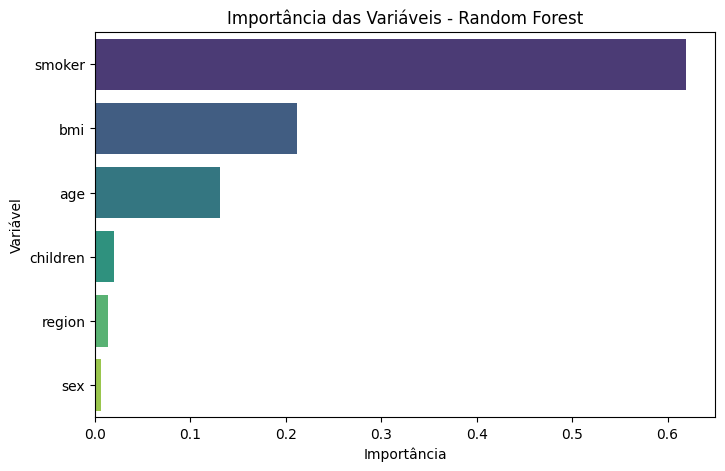

In [50]:
importances = {
    "age": 0.1306,
    "sex": 0.0062,
    "bmi": 0.2113,
    "children": 0.0194,
    "smoker": 0.6188,
    "region": 0.0138
}


df_importances = pd.DataFrame(list(importances.items()), columns=["Feature", "Importance"])

# Ordenar pela importância
df_importances = df_importances.sort_values(by="Importance", ascending=False)

# Plotar gráfico de barras
plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=df_importances, palette="viridis")
plt.title("Importância das Variáveis - Random Forest")
plt.xlabel("Importância")
plt.ylabel("Variável")
plt.show()


Para concluir, criei um novo cliente para realizar a previsão do custo médico do mesmo. Podemos atualizar as informações e observar a mudança no custo previsto.Lembrando que esse valor pode variar 2671 + ou -.

In [51]:
data = {'age': 45, 'sex':0, 'bmi': 26, 'children': 2, 'smoker': 1, 'region':2}
index = [0]
cust_df = pd.DataFrame(data, index)
cust_df

,age,sex,bmi,children,smoker,region
0,45,0,26,2,1,2


In [52]:

cost_pred = rf_model.predict(cust_df)
print("O custo desse novo cliente vai ser:", cost_pred)

O custo desse novo cliente vai ser: [28696.4143444]


# Previsão de Sobrevivência - Titanic

Primeiro passo nesse desafio foi importar os dados do titanic dataset, com o total de 12 colunas, inclusive da nossa variavel alvo "survived".

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Carregando os dados
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df_titanic = pd.read_csv(url)
print(df_titanic.head())
print(df_titanic.info())


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

Aqui observei que há muitos espaços vazios na coluna idade e cabine. A idade por ser uma variável importante, irei preencher esses espaços com a média de idade dos passageiros. Mas a Cabine por ser uma variável com alta cardinalidade não vai ajudar o nosso modelo.

In [54]:
# 2. ANÁLISE INICIAL: Vamos ver o que está faltando
print(df_titanic.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [55]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="titanic", explorative=True)
profile.to_file("titanic.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 7/7 [00:00<00:00, 18.08it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Aqui observei melhor as variaveis com alta cardinalidade que não serão uteis para o modelo.

In [56]:
df_titanic.nunique().sort_values(ascending=False)

,0
PassengerId,891
Name,891
Ticket,681
Fare,248
Cabin,147
Age,88
SibSp,7
Parch,7
Embarked,3
Pclass,3


Preenchi os espaços vazios da coluna idade, selecionei apenas as colunas mais importantes para o modelo e transformei as strings de sexo para 0 e 1.

In [57]:
# Preencher idades vazias com a média de idade dos passageiros
df_titanic['Age'] = df_titanic['Age'].fillna(df_titanic['Age'].mean())

# Selecionar apenas o que importa
# Pclass (Classe social), Sex, Age, SibSp (irmãos/cônjuges), Parch (pais/filhos), Fare (tarifa)
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
X = df_titanic[features]
y = df_titanic['Survived']

# Transformar Sexo em número (0 e 1)
X['Sex'] = X['Sex'].map({'female': 0, 'male': 1})

print("Dados limpos e prontos!")

Dados limpos e prontos!


/tmp/ipython-input-127998300.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Sex'] = X['Sex'].map({'female': 0, 'male': 1})


In [58]:
sobreviventes_por_sexo = df_titanic.groupby(['Sex', 'Survived']).size().unstack(fill_value=0)
sobreviventes_por_sexo.columns = ['Não Sobreviveu', 'Sobreviveu']

print("Número de Sobreviventes por Sexo:")
display(sobreviventes_por_sexo)

Número de Sobreviventes por Sexo:


,Não Sobreviveu,Sobreviveu
Sex,,
female,81,233
male,468,109


Verifiquei que mulheres tiveram uma taxa maior de sobrevivência.


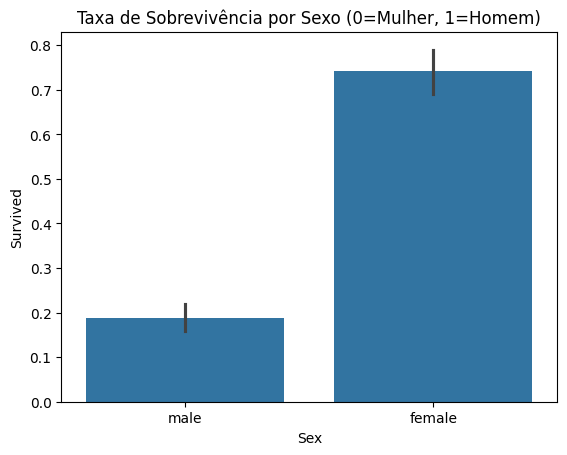

In [59]:
sns.barplot(x='Sex', y='Survived', data=df_titanic)
plt.title('Taxa de Sobrevivência por Sexo (0=Mulher, 1=Homem)')
plt.show()

Nesse gráfico podemos observar que a classe social foi determinante na taxa de sobrevivência.

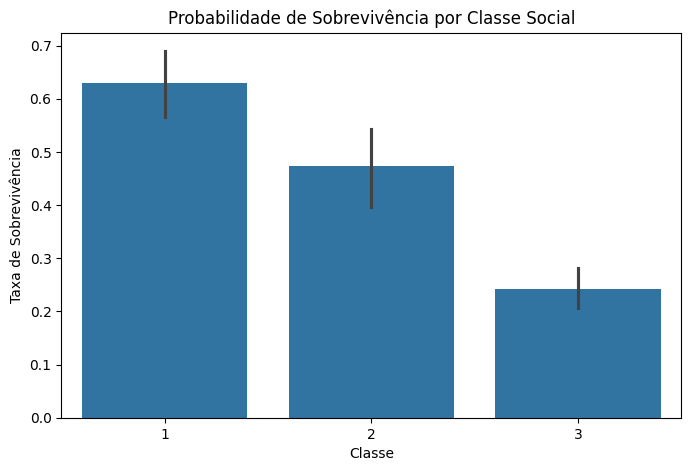

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

# Criando um gráfico que cruza Classe Social com Sobrevivência
plt.figure(figsize=(8,5))
sns.barplot(x='Pclass', y='Survived', data=df_titanic)

plt.title('Probabilidade de Sobrevivência por Classe Social')
plt.xlabel('Classe')
plt.ylabel('Taxa de Sobrevivência')
plt.show()

Esse gráfico reforça a ideia de que crianças tiveram prioridade no resgate

/tmp/ipython-input-2301510353.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survival_by_age = df_titanic.groupby('AgeGroup')['Survived'].mean().reset_index()


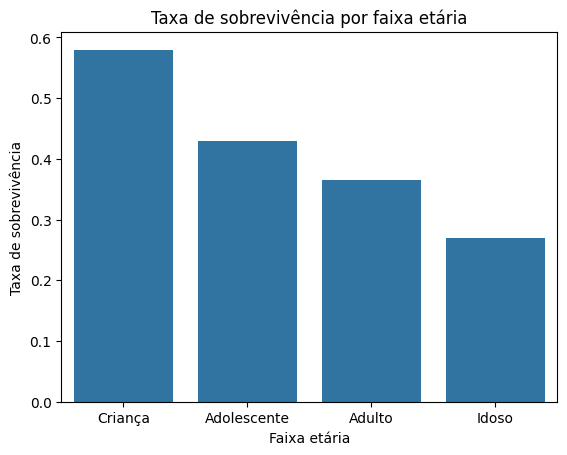

In [61]:
# Criar faixas de idade
bins = [0, 12, 18, 59, 100]
labels = ['Criança', 'Adolescente', 'Adulto', 'Idoso']
df_titanic['AgeGroup'] = pd.cut(df_titanic['Age'], bins=bins, labels=labels)

# Calcular taxa de sobrevivência por faixa etária
survival_by_age = df_titanic.groupby('AgeGroup')['Survived'].mean().reset_index()

# Plotar
sns.barplot(data=survival_by_age, x='AgeGroup', y='Survived')
plt.title('Taxa de sobrevivência por faixa etária')
plt.ylabel('Taxa de sobrevivência')
plt.xlabel('Faixa etária')
plt.show()

Esse gráfico mostra que famílias pequenas (2 a 4 pessoas) tiveram vantagem, enquanto famílias grandes e pessoas sozinhas tiveram taxas menores.


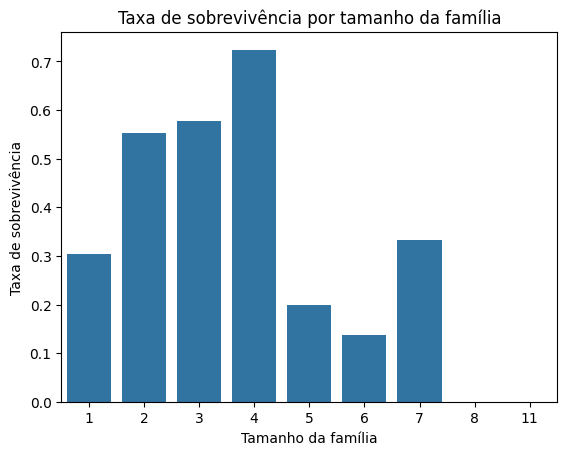

In [62]:
# Criar variável FamilySize
df_titanic['FamilySize'] = df_titanic['SibSp'] + df_titanic['Parch'] + 1

# Calcular taxa de sobrevivência por tamanho da família
survival_by_family = df_titanic.groupby('FamilySize')['Survived'].mean().reset_index()

# Plotar
sns.barplot(data=survival_by_family, x='FamilySize', y='Survived')
plt.title('Taxa de sobrevivência por tamanho da família')
plt.ylabel('Taxa de sobrevivência')
plt.xlabel('Tamanho da família')
plt.show()


Conclusão que tive a partir da análise: Os dados confirmam que gênero e classe social foram determinantes, mas também revelam que crianças e famílias pequenas tiveram maiores chances de sobrevivência, reforçando desigualdades sociais e logísticas do resgate.

Optei por utilizar o modelo de Regressão Logistica, por se tratar de um caso de classificação. O modelo obteve uma Acurácia sólida de 0.81.
- Precision: quando o modelo prevê que alguém não sobreviveu, está certo em 81% dos casos.Já as previsões de sobrevivência são corretas em 80% dos casos.
- Recall: 0.88 mostra que conseguiu capturar a maioria dos que realmente não sobreviveram. Mas 0.72 mostra que o modelo deixou escapar alguns sobreviventes.
- F1-score: 0.84 → equilíbrio muito bom. Na classe 1 foi 0.76, desempenho razoável, mas menor que na classe 0.


In [63]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

# 1. Dividir os dados em Treino (80%) e Teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

modelo_titanic = LogisticRegression()

modelo_titanic.fit(X_train, y_train)

y_pred = modelo_titanic.predict(X_test)

# 5. RESULTADOS
print(f"Acurácia: {accuracy_score(y_test, y_pred):.2f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

Acurácia: 0.81

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       105
           1       0.80      0.72      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



Com a Matriz de confusão podemos observar melhor a frequência de acertos e erros do modelo. Fica claro que o modelo foi mais pessimista em realção a sobrevivência. Pode ser influência de fatores externos.

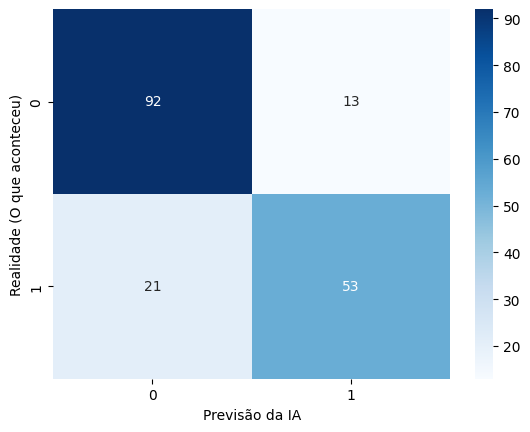

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Previsão da IA')
plt.ylabel('Realidade (O que aconteceu)')
plt.show()

Mesmo com acurácia de 81%, é importante destacar que o modelo não é perfeito e pode falhar em prever sobreviventes, o que, em contexto real, seria crítico.

Informações novas de uma pessoa apenas para exemplificação:

In [65]:
data = {'Pclass': 1, 'Sex': 1, 'Age':20, 'SibSp':1, 'Parch':0, 'Fare':25.9250}
index = [0]
cust_df = pd.DataFrame(data, index)
cust_df

,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,1,20,1,0,25.925


In [66]:
cost_pred = modelo_titanic.predict(cust_df)
print("Essa pessoa sobreviveria(0 = não, 1= sim): ", cost_pred)

Essa pessoa sobreviveria(0 = não, 1= sim):  [0]




```
# Isto está formatado como código
```

# Predição de cancelamento de clientes (churn)

Assim como nos desafios anteriores, o primeiro passo foi carregar os dados do Telco Customer Churn dataset e fazer uma primeira análise das informações.

In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_excel('/content/Telco_customer_churn[1].xlsx')

print(f"Base carregada: {df.shape[0]} clientes e {df.shape[1]} colunas.")

print("\nDados carregados com sucesso do Excel!")
print(df.head())



Base carregada: 7043 clientes e 33 colunas.

Dados carregados com sucesso do Excel!
   CustomerID  Count        Country       State         City  Zip Code  \
0  3668-QPYBK      1  United States  California  Los Angeles     90003   
1  9237-HQITU      1  United States  California  Los Angeles     90005   
2  9305-CDSKC      1  United States  California  Los Angeles     90006   
3  7892-POOKP      1  United States  California  Los Angeles     90010   
4  0280-XJGEX      1  United States  California  Los Angeles     90015   

                 Lat Long   Latitude   Longitude  Gender  ...        Contract  \
0  33.964131, -118.272783  33.964131 -118.272783    Male  ...  Month-to-month   
1   34.059281, -118.30742  34.059281 -118.307420  Female  ...  Month-to-month   
2  34.048013, -118.293953  34.048013 -118.293953  Female  ...  Month-to-month   
3  34.062125, -118.315709  34.062125 -118.315709  Female  ...  Month-to-month   
4  34.039224, -118.266293  34.039224 -118.266293    Male  ...  Mon

In [68]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="churn", explorative=True)
profile.to_file("churn.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 33/33 [00:01<00:00, 27.09it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [69]:
# Convertendo para numérico e removendo o que for nulo
df['Monthly Charges'] = pd.to_numeric(df['Monthly Charges'], errors='coerce')
df= df.dropna(subset=['Monthly Charges'])


A primeira comparação que resolvi fazer para entender os cancelamentos foi a média de meses dos clientes na empresa e o tipo de contrato. Pude perceber que o risco de abandono é muito maior em clientes novos. O primeiro ano e meio é o período crítico. Se o cliente passar da marca de 2 anos, a chance de ele permanecer fiel aumenta drasticamente.

In [70]:
# Comparando a média de meses na empresa (Tenure Months)
perfil_tenure = df.groupby('Churn Label')['Tenure Months'].mean()
print("Média de meses na empresa:")
print(perfil_tenure)

perfil_contrato = pd.crosstab(df['Contract'], df['Churn Label'], normalize='index') * 100
print("\n% de Churn por tipo de contrato:")
print(perfil_contrato)

Média de meses na empresa:
Churn Label
No     37.569965
Yes    17.979133
Name: Tenure Months, dtype: float64

% de Churn por tipo de contrato:
Churn Label            No        Yes
Contract                            
Month-to-month  57.290323  42.709677
One year        88.730482  11.269518
Two year        97.168142   2.831858


Com essas informações já podemos observar um perfil de Risco: Clientes com menos de 18 meses de relacionamento com a empresa. E um fator de risco: Quase 43% de Churn nos contratos mensais! É uma taxa altíssima. Quase metade dos clientes que assinam mês a mês acabam saindo.

/tmp/ipython-input-2997330185.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=perfil_tenure.index, y=perfil_tenure.values, palette="viridis")


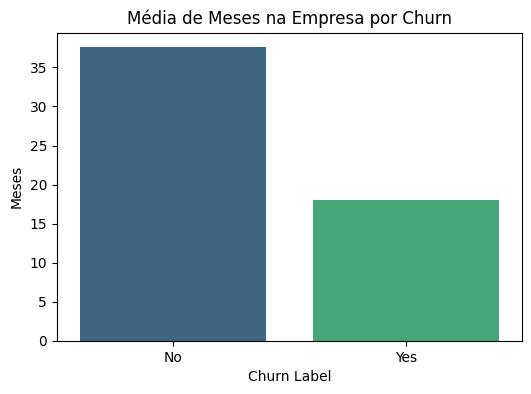

<Figure size 800x500 with 0 Axes>

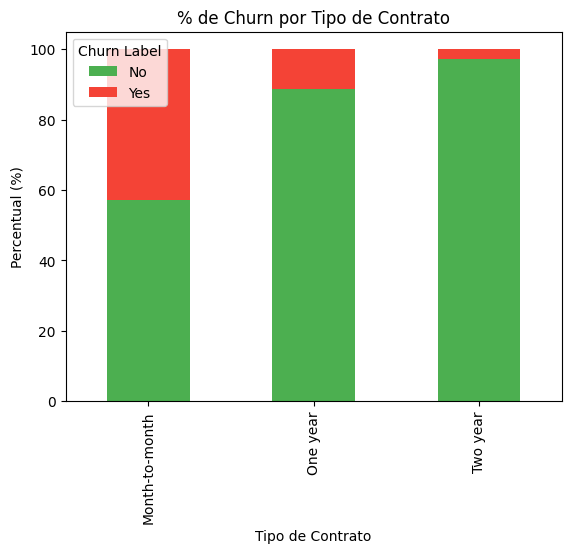

In [71]:
# Gráfico 1: Média de meses na empresa por churn
plt.figure(figsize=(6,4))
sns.barplot(x=perfil_tenure.index, y=perfil_tenure.values, palette="viridis")
plt.title("Média de Meses na Empresa por Churn")
plt.ylabel("Meses")
plt.xlabel("Churn Label")
plt.show()

# Gráfico 2: % de Churn por tipo de contrato
plt.figure(figsize=(8,5))
perfil_contrato.plot(kind="bar", stacked=True, color=["#4CAF50", "#F44336"])
plt.title("% de Churn por Tipo de Contrato")
plt.ylabel("Percentual (%)")
plt.xlabel("Tipo de Contrato")
plt.legend(title="Churn Label")
plt.show()

Aqui pude entender melhor os 3 principais motivos de cancelamento.
O maior motivo é o comportamento humano. O suporte técnico está "expulsando" os clientes.
Outro fator de risco é que a concorrência está oferecendo mais velocidade e limite de dados.

In [72]:
# 1. Quais os 3 principais motivos de quem sai (Churn Yes)?
print("--- Principais Motivos de Saída ---")
print(df[df['Churn Label'] == 'Yes']['Churn Reason'].value_counts().head(3))

--- Principais Motivos de Saída ---
Churn Reason
Attitude of support person                   192
Competitor offered higher download speeds    189
Competitor offered more data                 162
Name: count, dtype: int64


/tmp/ipython-input-3104814826.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_reasons.values, y=top_reasons.index, palette="magma")


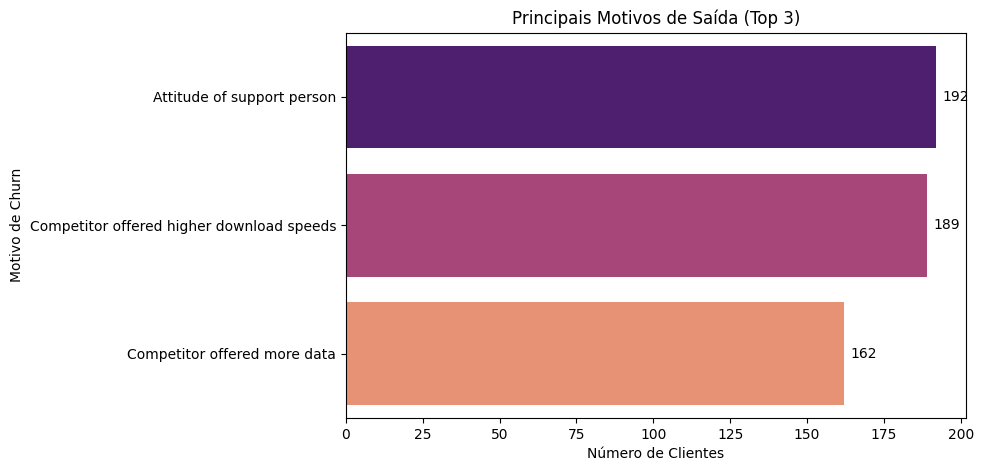

In [73]:
top_reasons = df[df['Churn Label'] == 'Yes']['Churn Reason'].value_counts().head(3)

# Gráfico de barras
plt.figure(figsize=(8,5))
sns.barplot(x=top_reasons.values, y=top_reasons.index, palette="magma")
plt.title("Principais Motivos de Saída (Top 3)")
plt.xlabel("Número de Clientes")
plt.ylabel("Motivo de Churn")

# Adicionando os valores nas barras
for i, v in enumerate(top_reasons.values):
    plt.text(v + 2, i, str(v), color='black', va='center')

plt.show()


Indo mais a fundo para entender o impacto do suporte no cancelamento, nesse gráfico podemos observar que o numero de cancelamento é muito maior quando o cliente não tem segurança online ou suporte técnico.

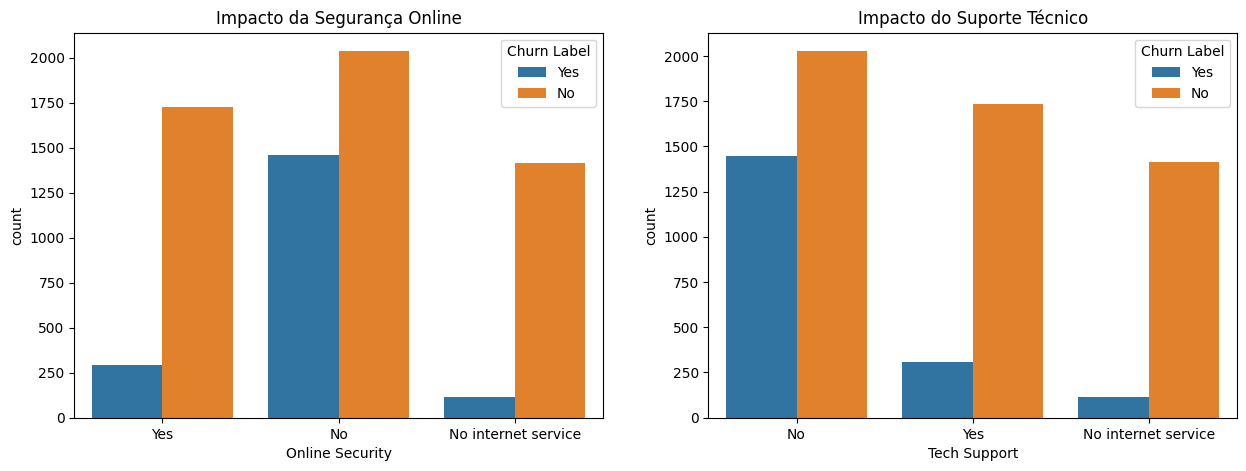

In [74]:

# Criando uma comparação de serviços de segurança
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(data=df, x='Online Security', hue='Churn Label', ax=axes[0])
axes[0].set_title('Impacto da Segurança Online')

sns.countplot(data=df, x='Tech Support', hue='Churn Label', ax=axes[1])
axes[1].set_title('Impacto do Suporte Técnico')

plt.show()

Depois de entender os principais perfis e fatores de risco, o próximo passo foi quantificar o impacto financeiro dos cancelamentos por mês. A empresa está perdendo $139 mil por mês em churn.


In [75]:
# 1. Calculando a perda total mensal
# No seu caso, Churn Value 1 significa que o cliente saiu
clientes_que_sairam = df[df['Churn Value'] == 1]
perda_total_mensal = clientes_que_sairam['Monthly Charges'].sum()
ticket_medio_perda = clientes_que_sairam['Monthly Charges'].mean()

print(f"--- RESULTADOS FINANCEIROS ---")
print(f"Prejuízo Mensal Total: $ {perda_total_mensal:.2f}")
print(f"Valor médio por cliente que cancela: $ {ticket_medio_perda:.2f}")
print(f"Total de clientes que saíram nesta base: {len(clientes_que_sairam)}")

--- RESULTADOS FINANCEIROS ---
Prejuízo Mensal Total: $ 139130.85
Valor médio por cliente que cancela: $ 74.44
Total de clientes que saíram nesta base: 1869


Pensando na priorização, criei um ranking filtrando quem tem maior chance de cancelar e ordenei pelo valor que ele representa (Valor do Tempo de Vida do Cliente) para uma ação imediata.

In [76]:
# Criando um ranking de prioridade para o time de marketing
# Filtramos apenas quem histórico diz que tem alto risco (ex: Churn Score > 80)
# E ordenamos pelo valor que ele representa (CLTV)

clientes_prioritarios = df[df['Churn Score'] > 80].sort_values(by='CLTV', ascending=False)

print("TOP 5 Clientes para ação imediata de retenção:")
print(clientes_prioritarios[['CustomerID', 'CLTV', 'Churn Score', 'Monthly Charges']].head(5))

TOP 5 Clientes para ação imediata de retenção:
      CustomerID  CLTV  Churn Score  Monthly Charges
644   1323-OOEPC  6481           87            98.40
1017  5089-IFSDP  6424           89           109.45
488   4143-HHPMK  6402           98            85.35
779   1891-FZYSA  6363           82            89.95
997   1725-IQNIY  6274           90           109.75


Resolvi utilizar o modelo de Random Forest para a predição de classificação. Tive que fazer a transformação de algumas categorias para numeros, filtrei apenas as principais categorias da tabela, e selecionei a variavel Churn Value como alvo.

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

df_ml = df.copy()

# Transformando categorias em números (Label Encoding simples)
df_ml['Contract_Code'] = df_ml['Contract'].map({'Month-to-month': 0, 'One year': 1, 'Two year': 2})
df_ml['Security_Code'] = df_ml['Online Security'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
df_ml['Support_Code'] = df_ml['Tech Support'].map({'Yes': 1, 'No': 0, 'No internet service': 0})

# Definindo as Features (X) e o Alvo (y)
features = ['Tenure Months', 'Monthly Charges', 'Contract_Code', 'Security_Code', 'Support_Code']
X = df_ml[features]
y = df_ml['Churn Value'] # 1 para saiu, 0 para ficou

# Dividindo em Treino (80%) e Teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Variáveis preparadas e dados divididos!")

Variáveis preparadas e dados divididos!


In [78]:
# 2. Criando e treinando o modelo
modelo_churn = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_churn.fit(X_train, y_train)

# 3. Fazendo as previsões
previsoes = modelo_churn.predict(X_test)

# 4. Gerando o Relatório
print("--- RELATÓRIO DE DESEMPENHO DA IA ---")
print(classification_report(y_test, previsoes))

--- RELATÓRIO DE DESEMPENHO DA IA ---
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1009
           1       0.57      0.51      0.54       400

    accuracy                           0.75      1409
   macro avg       0.69      0.68      0.68      1409
weighted avg       0.74      0.75      0.75      1409



Em resumo, o modelo está bom para identificar quem não cancela, mas apenas 51% dos clientes que realmente vão cancelar. Ou seja, dos 139 mil que a empresa perde, a IA consegue "avisar" sobre aproximadamente R$71.000,00 desse valor.
Temos que levar em conta que há fatores humanos (como a "atitude do atendente") que são imprevisíveis para a IA apenas com números.

A Precisão (0.57) mostra que quando a IA aponta para um cliente e diz "Ele vai sair", ela acerta 57% das vezes.
Significa que mais da metade das ações de retenção (cupons, ligações) serão direcionadas para as pessoas certas, evitando desperdiçar dinheiro com quem já pretendia ficar.



# Detecção de Fraude em Cartões de Crédito

Primeiro passo foi carregar o credit Card Fraud Detection Dataset e analizar as informações.

In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Carregando o dataset (MLG-ULB Credit Card Fraud)
url = "https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv"
df_fraude = pd.read_csv(url)
df_fraude.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [80]:
print(df_fraude.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [81]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df_fraude, title="fraude", explorative=True)
profile.to_file("fraude.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 31/31 [00:19<00:00,  1.56it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Podemos observar que o grande desafio é o desbalanceamento, sem manipular os dado, a IA vai ignorar se encontrar uma fraude, porque matematicamente não vale a pena ela se esforçar para aprender algo que só acontece 0,17% das vezes

--- DISTRIBUIÇÃO DAS TRANSAÇÕES ---
Legítimas (0): 284315
Fraudes (1): 492


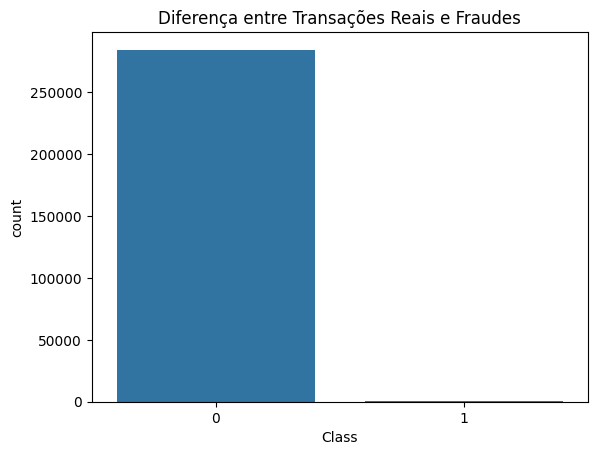

In [82]:
# Verificando o desbalanceamento real
contagem = df_fraude['Class'].value_counts()
print("--- DISTRIBUIÇÃO DAS TRANSAÇÕES ---")
print(f"Legítimas (0): {contagem[0]}")
print(f"Fraudes (1): {contagem[1]}")

# Mostrando visualmente a diferença entre transações reias e fraudes
sns.countplot(x='Class', data=df_fraude)
plt.title('Diferença entre Transações Reais e Fraudes')
plt.show()

Com base na categoria "Amount" conseguimos ver a quantia em dinheiro das fraudes. Podemos observar muitas fraudes pequenas e poucas fraudes gigantes que puxam a média para 122.

In [83]:
print("--- RESUMO FINANCEIRO DAS FRAUDES ---")
print(df_fraude[df_fraude['Class'] == 1]['Amount'].describe())

--- RESUMO FINANCEIRO DAS FRAUDES ---
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


Com a coluna Time, podemos observar quando as fraudes acontecem. Este gráfico mostra a frequência das transações ao longo do tempo (representado em segundos, cobrindo aproximadamente 48 horas).

A Linha Azul (Normal) tem dois picos altos e um vale profundo no meio (perto de 100.000 segundos). Esse vale é a madrugada, quando as pessoas estão dormindo e param de usar o cartão.

A Linha Vermelha (Fraude) é muito mais "estável". Onde a linha azul cai drasticamente (madrugada), a linha vermelha não cai na mesma proporção.

Ou seja, muitas fraudes acontecem na madrugada enquanto os clientes estão dormindo.

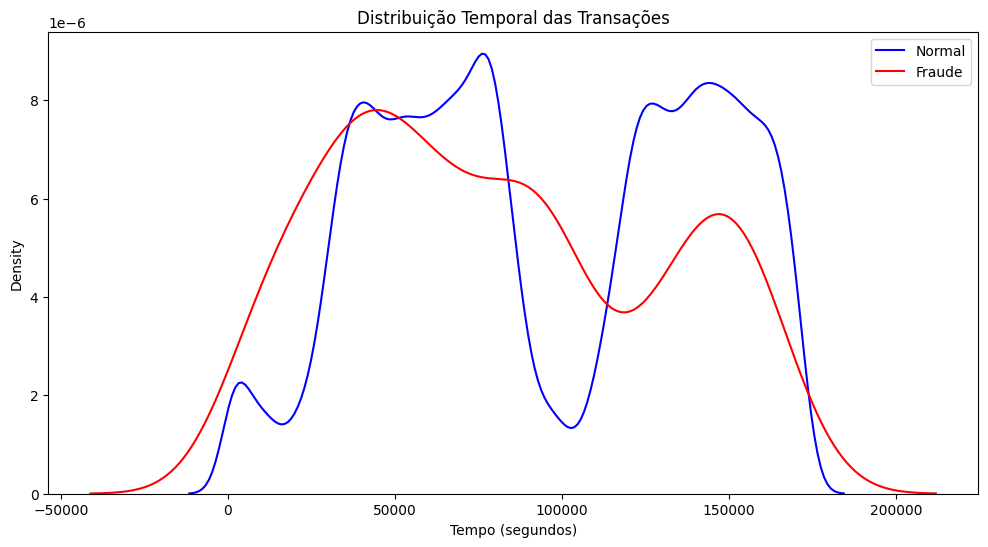

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# Comparando o tempo das transações normais vs fraudes
plt.figure(figsize=(12, 6))

sns.kdeplot(df_fraude[df_fraude['Class'] == 0]['Time'], label='Normal', color='blue')
sns.kdeplot(df_fraude[df_fraude['Class'] == 1]['Time'], label='Fraude', color='red')

plt.title('Distribuição Temporal das Transações')
plt.xlabel('Tempo (segundos)')
plt.legend()
plt.show()

Como as fraudes são pouquíssimas, vamos equilibrar o jogo para que o modelo não ignore os sinais da linha vermelha. Agora com os dados equilibrados a IA vai considerar as fraudes com o mesmo peso das transações normais.

--- NOVO EQUILÍBRIO DOS DADOS ---
Class
1    492
0    492
Name: count, dtype: int64


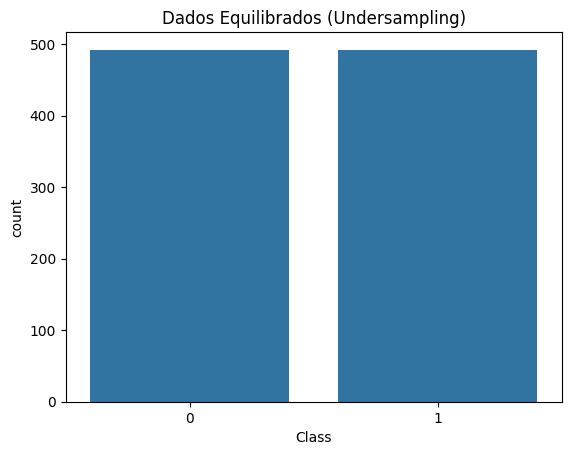

In [85]:
# 1. Separando as transações
fraudes = df_fraude[df_fraude['Class'] == 1]
normais = df_fraude[df_fraude['Class'] == 0]

# 2. Criando uma amostra de transações normais igual ao número de fraudes (492)
normais_sample = normais.sample(n=492, random_state=42)

# 3. Juntando os dois para criar o dataset de treino equilibrado
df_balanceado = pd.concat([fraudes, normais_sample])

# Verificando o novo equilíbrio
print("--- NOVO EQUILÍBRIO DOS DADOS ---")
print(df_balanceado['Class'].value_counts())

# Visualizando o novo cenário
sns.countplot(x='Class', data=df_balanceado)
plt.title('Dados Equilibrados (Undersampling)')
plt.show()

Para treinar e testar, utilizei o modelo de Random Forest.
A métrica principal utilizada para avaliar o modelo é o recall, que mostra que de cada 100 fraudes que tentaram passar, a IA bloqueou 91.
A precisão aponta que quando a IA diz "Isso é fraude", ela está correta 99% das vezes.

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Preparando X (dados) e y (resultado)
X = df_balanceado.drop(['Class'], axis=1)
y = df_balanceado['Class']

# 2. Divisão treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Treinando o modelo
modelo_fraude = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_fraude.fit(X_train, y_train)

# 4. Avaliando
previsoes = modelo_fraude.predict(X_test)
print("--- DESEMPENHO NA DETECÇÃO DE FRAUDE ---")
print(classification_report(y_test, previsoes))

--- DESEMPENHO NA DETECÇÃO DE FRAUDE ---
              precision    recall  f1-score   support

           0       0.92      0.99      0.95        98
           1       0.99      0.91      0.95        99

    accuracy                           0.95       197
   macro avg       0.95      0.95      0.95       197
weighted avg       0.95      0.95      0.95       197



##Impacto Financeiro
Pergunta: Qual o custo real de fraudes não detectadas versus o custo de falsos alarmes?

Fraude não detectada: É o custo direto. O banco perde o valor da transação (média de $122), os custos operacionais de estorno (chargeback) e a possível perda de confiança do cliente.

Falso Alarme: É o custo de oportunidade e suporte. Se você bloqueia um cliente legítimo, ele pode ficar frustrado, abandonar o cartão ou sobrecarregar o suporte pedindo o desbloqueio.

O Balanço: Nesse modelo, como a precisão foi de 99%, o custo de falsos alarmes é mínimo. O maior foco deve ser o custo das fraudes não detectadas.

##Experiência do Cliente
Como equilibrar a redução de fraudes sem prejudicar a jornada de clientes legítimos?

Como temos alta precisão, podemos aplicar bloqueios automáticos em casos de alta confiança.

Para os casos "suspeitos" (onde o modelo não tem 100% de certeza), em vez de bloquear o cartão, o sistema dispara uma notificação no celular do cliente pedindo confirmação.

Isso mantém a jornada fluida. O cliente legítimo só confirma a compra, e o fraudador é barrado antes de concluir o crime.

##Métrica Prioritária
Qual métrica deve guiar a otimização e por que essa escolha importa?

A Métrica é o RECALL:No contexto bancário, "deixar um ladrão passar" é muito mais perigoso do que "pedir confirmação para um cliente bom". O Recall garante que estamos capturando o máximo possível de fraudes. Uma acurácia de 99% seria inútil se o Recall fosse baixo, pois estaríamos ignorando justamente o que o banco quer encontrar: a agulha no palheiro.

##Prontidão Operacional
Pergunta: O modelo está em condições de ser aplicado em produção? Quais os riscos e limitações?

Sim, o modelo apresenta métricas de excelência (F1-Score de 0.95), o que é altíssimo para o mercado.

Riscos e Limitações: O comportamento dos fraudadores muda. O modelo precisa ser re-treinado constantemente.

Risco do Undersampling: Como usamos poucos dados "normais" para treinar. Em produção, seria ideal testar outras técnicas (gerar fraudes sintéticas) para não descartar tantas transações legítimas e tornar o modelo ainda mais robusto.
